# The number of sunspots prediction

In [1]:
import os
import sys
import logging
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# # Graphics in retina format are more sharp and legible
# %config InlineBackend.figure_format = 'retina'

# Increase the default plot size and set the color scheme
plt.rcParams["figure.figsize"] = 14, 6
plt.rcParams["image.cmap"] = "viridis"

import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sarimannx import SARIMANNX

In [3]:
np.random.seed(888)

In [4]:
def tsplot(y, lags=60, figsize=(12, 7)):
    """Plots time series, its ACF and PACF, calculates Dickey–Fuller test.
    
    y - timeseries
    lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, np.ndarray):
        y = np.array(y)
    
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
        
    ts_ax.plot(y)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

## Explore the data

In [5]:
df = pd.read_csv("./Data/SUNSPOTS.csv")

In [6]:
df.head()

,year,sunspot_number,std,nobs,definitive
0,1700,8.3,-1.0,-1,1
1,1701,18.3,-1.0,-1,1
2,1702,26.7,-1.0,-1,1
3,1703,38.3,-1.0,-1,1
4,1704,60.0,-1.0,-1,1


Train test split

In [7]:
y_train, y_test = df.sunspot_number.values[:-50], df.sunspot_number.values[-50:]

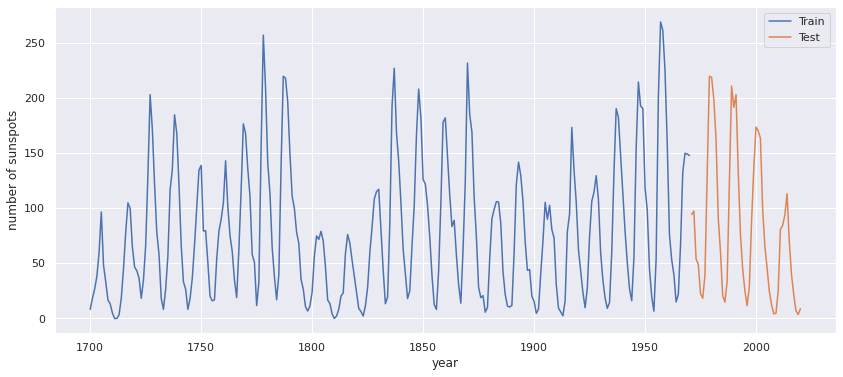

In [8]:
plt.plot(df.year[:-50], y_train, label="Train")
plt.plot(df.year[-50:], y_test, label="Test")
plt.xlabel("year")
plt.ylabel("number of sunspots")
plt.legend();

Use square root transformation to avoid negative predictions

In [9]:
y_train = np.sqrt(y_train)

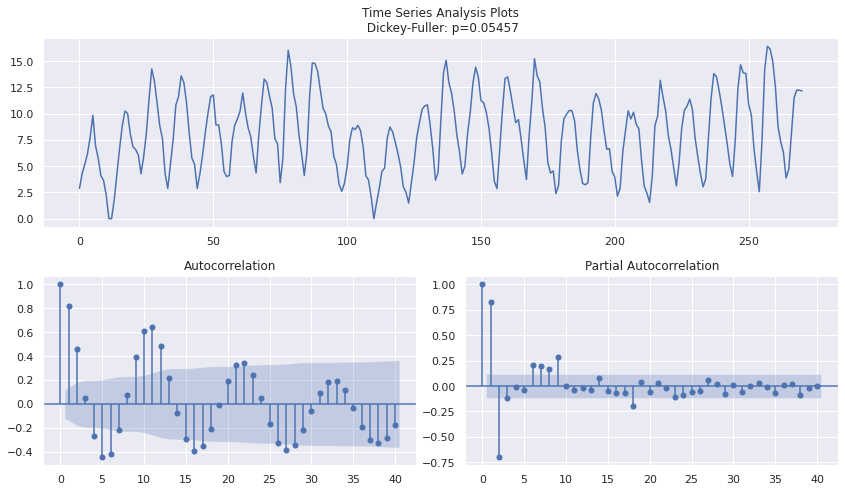

In [10]:
tsplot(y_train, lags=40)

Try one seasonal differencing with season length 11 and one first order differencing

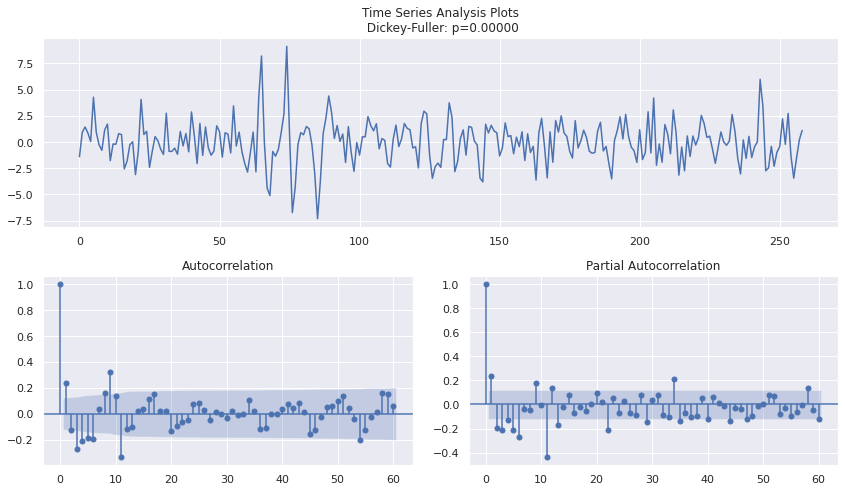

In [11]:
diff_y_train = y_train[11:] - y_train[:-11]
tsplot(diff_y_train[1:] - diff_y_train[:-1])

After differencings, the time series looks stationary

Received following hyperparameters:
* $p$ and $r$ set to 6, as the last significant lag on the PACF, after which, most others are not significant.
* $P$ and $R$ set to (9, 11) as also significant lags on PACF, but greater than 6.
* $q$ and $g$ set to 6, as the last significant lag on the ACF, after which, most others are not significant.
* $Q$ and $G$ set to (9, 11) as also significant lags on ACF, but greater than 6.
* $d$ is 1
* $D$ is 1
* $s$ is 11

## Train the model

In [12]:
# Set logging config for logging training progress
logging.basicConfig(level=logging.INFO,
                    format='%(levelname)s - %(message)s')

In [13]:
model = SARIMANNX(order=(6, 6, 1, 6, 6),
                  seasonal_order=((9, 11), (9, 11), 1, (9, 11), (9, 11), 11),
                  ann_hidden_layer_sizes=(5,), ann_activation="tanh", trend="n",
                  optimize_init_shocks=True, grad_clip_value=1e+140, max_grad_norm=10,
                  logging_level=logging.INFO, solver="L-BFGS-B", 
                  options={"maxiter": 500, "gtol": 1e-5})

In [ ]:
model, preds_resids = model.fit(y_train, return_preds_resids=True)

Looking at the final loss and number of iterations

In [15]:
model.loss_

0.7486370033662108

In [16]:
model.n_iter_

136

Inspect the residuals of the model

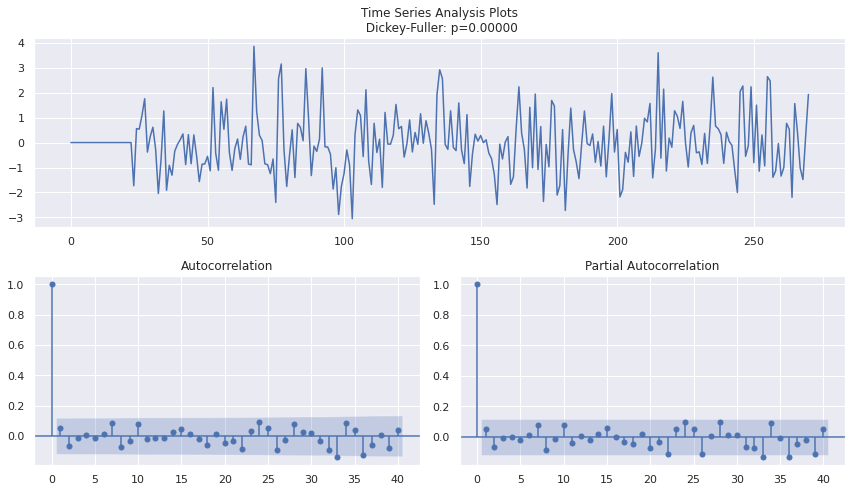

In [17]:
tsplot(preds_resids["residuals"], lags=40)

Residuals looks stationary with zero mean and without apparent autocorrelations

## Test the model

Collect one-step predictions

In [18]:
y_test_preds = np.empty_like(y_test)
for i in range(y_test_preds.shape[0]):
    y_test_preds[i] = (model.predict(np.sqrt(y_test[:i])))**2

In [19]:
y_train_test_preds = np.hstack([preds_resids["predictions"]**2, y_test_preds])

Calculate MSE values

In [20]:
mse_train_test = np.mean((df.sunspot_number.values - y_train_test_preds) ** 2)
mse_train = np.mean((df.sunspot_number.values[:-50] - y_train_test_preds[:-50]) ** 2)
mse_test = np.mean((y_test - y_test_preds) ** 2)
print(f"Train MSE: {mse_train:.2f}, Test MSE {mse_test:.2f}")

Train MSE: 411.60, Test MSE 822.92


Plot true values vs predictions

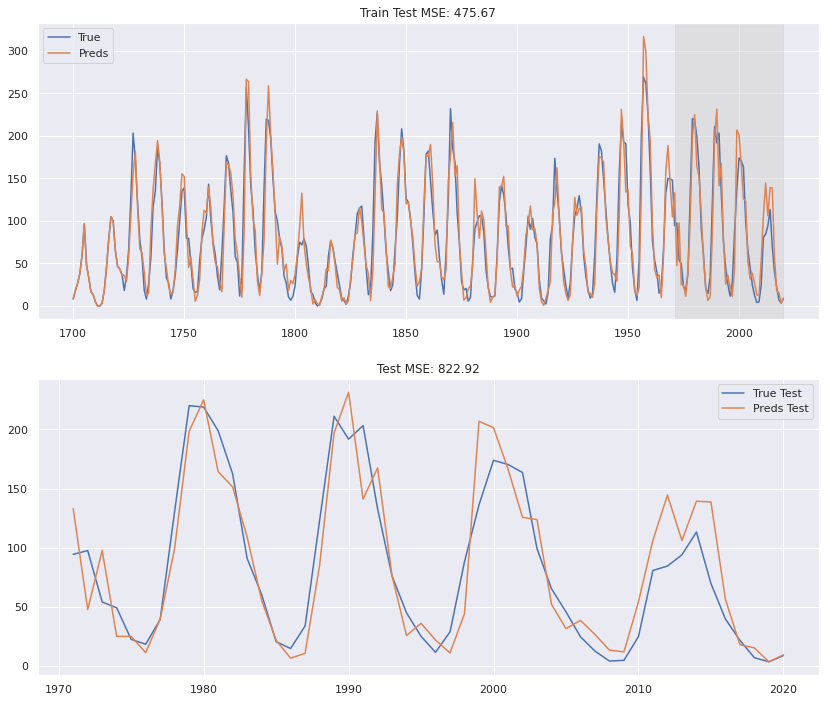

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(14, 12))

axs[0].plot(df.year, df.sunspot_number, label="True")
axs[0].plot(df.year, y_train_test_preds, label="Preds")
axs[0].axvspan(df.year.iloc[-50], df.year.iloc[-1], alpha=0.5, color='lightgrey')
axs[0].set_title(f"Train Test MSE: {mse_train_test:.2f}")
axs[0].legend();

axs[1].plot(df.year[-50:], y_test, label="True Test")
axs[1].plot(df.year[-50:], y_test_preds, label="Preds Test")
axs[1].set_title(f"Test MSE: {mse_test:.2f}")
axs[1].legend();